In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
from imports import *

In [3]:
model_dir = '/export/home/srasp/TF_models/'
model_fn = 'saved_keras_model_0220a.h5'
mean_fn = 'mean_nolat_0213.nc'
std_fn = 'std_nolat_0213.nc'

In [4]:
model_path = model_dir + model_fn
mean_path = model_dir + mean_fn
std_path = model_dir + std_fn

In [5]:
inps = ['TBP','QBP','PS','SHFLX','LHFLX','dTdt_adiabatic','dQdt_adiabatic']
outps = ['TPHYSTND_NORAD','PHQ']

In [20]:
data_dir = '/beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05_old_matlab/'
aqua_fn = 'AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-05-00000.nc'
aqua_pattern = data_dir + 'AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-*-0[1-5]-00000.nc'

In [21]:
class ModelDiagnostics(object):
    """
    Model diagnostics class.
    """
    def __init__(self, model_path, feature_vars, target_vars,
                 mean_path, std_path, valid_file_pattern, 
                 nlat=64, nlon=128, nlev=30):
        """
        TF version
        """
        self.model_path = model_path
        self.model = keras.models.load_model(model_path, custom_objects={"tf": tf})
        self.mean = nc.Dataset(mean_path, 'r')
        self.std = nc.Dataset(std_path, 'r')
        self.nlat = nlat; self.nlon = nlon; self.nlev = nlev
        self.ntime = 48
        self.ngeo = nlat * nlon
        self.feature_vars, self.target_vars = (feature_vars, target_vars)
        self.valid_files = sorted(glob(valid_file_pattern))

    def get_tp(self, var, idate, itime):
        """Return denormalized predictions and targets for one variable
        [lat, lon, lev]
        """
        # Get feature array
        f, t = self._get_ft(idate, itime)
        p = self._get_pred(f)
        var_idx = self.target_vars.index(var)
        t, p = (self.unravel(t), self.unravel(p))
        return self._denorm(t, 't')[:, :, var_idx], self._denorm(p, 't')[:, :, var_idx]
            
    def _get_f_or_t(self, idate, itime, f_or_t):
        with nc.Dataset(self.valid_files[idate], 'r') as ds:
            arr = []
            vars = self.feature_vars if f_or_t == 'f' else self.target_vars
            for var in vars:
                da = (ds[var][:] - self.mean[var][:]) / self.std[var][:]
                if da.ndim == 4:   # 3D variables [time, lev, lat, lon] --> [sample, lev]
                    a = np.rollaxis(da, 1, 4).reshape(-1, self.nlev)
                elif da.ndim == 3:   # 2D variables [time, lat, lon]
                    a = np.rollaxis(np.tile(da[itime].reshape(-1), (self.nlev, 1)), 0, 2)
                elif da.ndim == 1:   # lat
                    a = np.rollaxis(np.tile(da, (self.ntime, self.nlev, self.nlon, 1)), 
                                    1, 4).reshape(-1, 30)
                else:
                    raise Exception('Incompatible number of dimensions')
                arr.append(a)
            arr = np.expand_dims(np.rollaxis(np.array(arr), 0, 2), 3) # [sample, feature, lev, 1]
        arr =  arr[:, :, -self.nlev:][:, ::-1]
        if itime is not None: arr = arr[itime*self.ngeo:(itime+1)*self.ngeo]
        return arr
    
    def _get_ft(self, idate, itime):
        return self._get_f_or_t(idate, itime, 'f'), self._get_f_or_t(idate, itime, 't')
    
    def _get_pred(self, f):
        return self.model.predict(f, batch_size=1024)
    
    def _denorm(self, x, f_or_t):
        for i, var in enumerate(self.feature_vars if f_or_t == 'f' else self.target_vars):
            m, s = [np.rollaxis(ds[var][-self.nlev:][::-1], 0, 3) 
                    for ds in [self.mean, self.std]]
            x[:, :, i, :] = x[:, :, i, :] * s + m
        return x
    
    def unravel(self, x):
        return x.reshape(self.nlat, self.nlon, -1, self.nlev)
    
    def compute_stats(self, niter=None):
        """
        Compute statistics over entire dataset [lat, lon, lev].
        bias = mean(preds) - mean(true)
        mse = sse(preds, true) / n_samples
        rel_mse = mse / std(true)
        std_error = std(preds) - std(true)
        """
        psum = np.zeros((self.ngeo, len(self.target_vars)*self.nlev))
        tsum = np.copy(psum); sse = np.copy(psum)
        psqsum = np.copy(psum); tsqsum = np.copy(psum)
        ndates = len(self.valid_files) if niter is None else niter
        n = ndates * self.ntime
        for idate in tqdm(range(ndates)):
            f_date, t_date = self._get_ft(idate, None)   # Full file
            for itime in range(self.ntime):
                f = f_date[itime*self.ngeo:(itime+1)*self.ngeo]
                t = t_date[itime*self.ngeo:(itime+1)*self.ngeo]
                # Get predictions
                p = self.model.predict_on_batch(f)  # [ngeo samples, z]
                # Unscale outputs at this level
                t, p = (self.unravel(t), self.unravel(p))
                t = self._denorm(t, 't')
                p = self._denorm(p, 't')
                t, p = [a.reshape(-1, len(self.target_vars)*self.nlev) for a in [t, p]]
                # Compute statistics
                psum += p; tsum += t
                psqsum += p ** 2; tsqsum += t ** 2
                sse += (t - p) ** 2


        # Compute average statistics
        self.stats_dict = {}
        pmean = psum / n; tmean = tsum / n
        self.bias = pmean - tmean; self.stats_dict['bias'] = self.bias
        self.mse = sse / n; self.stats_dict['mse'] = self.mse
        self.pred_var = (psqsum / n - pmean ** 2) * n / (n - 1)  # Sample variance
        self.stats_dict['pred_var'] = self.pred_var
        self.true_var = (tsqsum / n - tmean ** 2) * n / (n - 1)
        self.stats_dict['true_var'] = self.true_var
    
    def mean_stats(self, cutoff_level=9):
        expl_var_str = f'expl_var_cut{cutoff_level}'
        df = pd.DataFrame(
            index=self.target_vars + ['all'],
            columns=list(self.stats_dict.keys()) + [expl_var_str])
        # Compute statistics for each variable
        for var in self.target_vars + ['all']:
            sl = slice(0, None) if var == 'all' else \
                slice(self.target_vars.index(var), self.target_vars.index(var)+1, 1)
            for stat_name, stat in self.stats_dict.items():
                re_stat = self.unravel(stat)[:, :, sl]
                df.loc[var, stat_name] = np.mean(re_stat)

            df.loc[var, expl_var_str] = np.mean((1. - (
                 np.mean(self.unravel(self.mse)[:, :, sl], axis=(0, 1)) / 
                 np.mean(self.unravel(self.true_var)[:, :, sl], axis=(0, 1))
            ).reshape(-1, self.nlev))[:, :cutoff_level])
        return df

In [22]:
diag = ModelDiagnostics(model_path, inps, outps, mean_path, std_path, aqua_pattern)

/export/home/srasp/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [23]:
diag.compute_stats()


  0%|          | 0/15 [00:00<?, ?it/s]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/export/home/srasp/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/export/home/srasp/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/export/home/srasp/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 15/15 [08:14<00:00, 32.99s/it]


In [24]:
diag.mean_stats()

,bias,mse,pred_var,true_var,expl_var_cut9
TPHYSTND_NORAD,5.52502e-06,9.97225e-09,5.65798e-09,2.49891e-09,-2.19704e+09
PHQ,-6.03639e-09,3.80054e-14,1.22674e-14,2.35917e-14,-7.93986
all,2.75949e-06,4.98614e-09,2.829e-09,1.24947e-09,-1.09852e+09


In [62]:
diag.mse[:, None].shape

(8192, 1, 60)

In [8]:
t, p = diag.get_tp('TPHYSTND_NORAD', 4, 47)

In [ ]:
diag.valid_files[4]

In [91]:
def plot_double_slice(t, p, var=None, unit='', **kwargs):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    I1 = axes[0].imshow(t, **kwargs)
    I2 = axes[1].imshow(p, **kwargs)
    cb1 = fig.colorbar(I1, ax=axes[0], orientation='horizontal')
    cb2 = fig.colorbar(I2, ax=axes[1], orientation='horizontal')
    cb1.set_label(unit); cb2.set_label(unit)
    axes[0].set_title('SP-CAM Truth')
    axes[1].set_title('CBRAIN Predictions')
    plt.show()

In [92]:
range_dict = {
    'SPDT': [-5e-4, 5e-4],
    'SPDQ': [-5e-7, 5e-7],
    'QRL': [-2e-4, 2e-4],
    'QRS': [-1.2e-4, 1.2e-4],
    'TPHYSTND_NORAD': [-5e-4, 5e-4],
    'PHQ': [-5e-7, 5e-7],
}

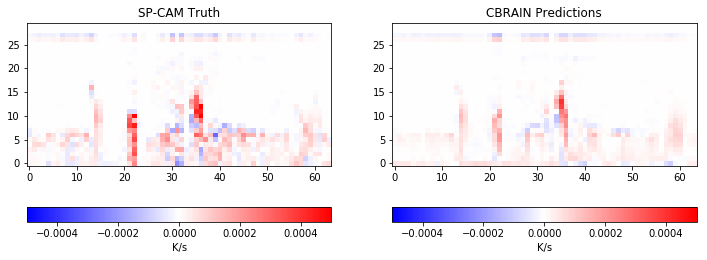

In [93]:
plot_double_slice(t[:, 0, :].T, p[:, 0, :].T, unit='K/s', cmap='bwr', 
                  vmin=-5e-4, vmax=5e-4, origin='lower')

In [33]:
dg = DataGenerator(
    '/scratch/srasp/preprocessed_data/', 
    'purecrm_essv2_train_sample1_shuffle_features.nc',
    'purecrm_essv2_train_sample1_shuffle_targets.nc',
    1024,
    'purecrm_essv2_train_sample1_norm.nc',
    'feature_means', 'feature_stds', None, 'target_stds'
)

Generator will have 23494656 samples in 22944 batches
Features have shape 152; targets have shape 120


In [34]:
dg.feature_norms

[array([  2.24381042e+02,   2.17487885e+02,   2.01357346e+02,
          2.19624695e+02,   2.16209274e+02,   2.11214523e+02,
          2.06991455e+02,   2.05739365e+02,   2.06342316e+02,
          2.07739578e+02,   2.09428741e+02,   2.11177322e+02,
          2.13806885e+02,   2.17677994e+02,   2.23149429e+02,
          2.29851227e+02,   2.37370834e+02,   2.45330429e+02,
          2.53404984e+02,   2.60647308e+02,   2.66350372e+02,
          2.70272369e+02,   2.72896820e+02,   2.74970703e+02,
          2.76562622e+02,   2.78152466e+02,   2.79706024e+02,
          2.81170074e+02,   2.82449646e+02,   2.83703918e+02,
          1.53170208e-06,   1.49748030e-06,   1.23334496e-06,
          1.32375135e-06,   1.29027717e-06,   1.26324494e-06,
          1.27624025e-06,   1.33082233e-06,   1.48173126e-06,
          1.97669056e-06,   3.71627448e-06,   8.72106557e-06,
          2.02070405e-05,   4.32628549e-05,   8.69502765e-05,
          1.64763391e-04,   2.99866806e-04,   5.36574342e-04,
        

In [35]:
next(dg.return_generator())

/data11/home/srasp/repositories/CBRAIN-Keras-Diagnostics/keras_network/data_generator.py:76: RuntimeWarning: invalid value encountered in true_divide
  if target_norms is not None: y = (y - target_norms[0]) / target_norms[1]


(array([[ -9.09901714e+00,  -1.07977028e+01,  -1.21291475e+01, ...,
          -1.45593825e+06,  -5.83981171e+01,  -7.67413974e-01],
        [ -9.09448814e+00,  -1.07882509e+01,  -1.21453743e+01, ...,
           1.28643810e+07,  -5.83979149e+01,  -7.72784829e-01],
        [ -9.19097996e+00,  -1.09083338e+01,  -1.22875395e+01, ...,
          -2.35728425e+06,  -5.83986664e+01,  -7.72784829e-01],
        ..., 
        [ -9.08297729e+00,  -1.07733841e+01,  -1.21290474e+01, ...,
           7.19276800e+06,  -5.83978958e+01,  -7.72784829e-01],
        [ -9.10054970e+00,  -1.07877979e+01,  -1.21383047e+01, ...,
           1.28270150e+07,  -5.83975906e+01,  -7.72784829e-01],
        [ -9.09198570e+00,  -1.07781277e+01,  -1.21491404e+01, ...,
           2.54618000e+06,  -5.83981743e+01,  -7.71383286e-01]], dtype=float32),
 array([[        nan,         nan, -0.09872468, ...,  1.06896222,
          0.99491262,  0.78771651],
        [        nan,         nan, -0.08812714, ...,  0.        ,
         

In [38]:
norm = xr.open_dataset('/scratch/srasp/preprocessed_data/purecrm_essv2_norm-by-var_train_sample1_norm.nc')

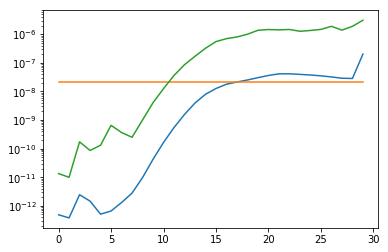

In [45]:
plt.plot(norm['feature_stds'][120:150])
plt.plot(norm['feature_stds_by_var'][120:150])
plt.plot(norm['feature_maxs'][120:150] - norm['feature_mins'][120:150])
plt.gca().set_yscale('log')

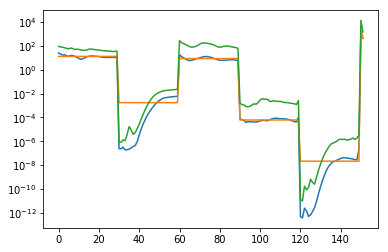

In [46]:
plt.plot(norm['feature_stds'][:])
plt.plot(norm['feature_stds_by_var'][:])
plt.plot(norm['feature_maxs'][:] - norm['feature_mins'][:])
plt.gca().set_yscale('log')